# AirBnB Bookings

For this project I am using Trifacta Wrangler for data cleansing/engineering and H2o.ai flow to fit the model. My objective was to see whether this stack was more productive than using R Studio, particularly for data preprocessing. 

The code outlined below is a combination of Trifacta Recipe and CoffeeScript produced by H2O flow, with some Python for data viz using matplotlib.

AirBnB New User Bookings was a popular recruiting competition that challenged Kagglers to predict the first country where a new user would book travel. New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

The goal is to predict in which country a new user will make his or her first booking. There are 12 possible outcomes of the destination country and the datasets consist of a list of users with their demographics, web session records, and some summary statistics.

This competition was appealing because it possesses the kind of challenges you’d experience within a real commercial project, but on a manageable scale: 
- the datasets have lot of NaNs and some other random values so good preprocessing is the primary key to getting a good solution
- significant number of classifications
- highly unbalanced classes 
- unfamiliar evaluation measure
- the data was not too big if you exclude the sessions data (as others have done)

It also no coincidence that I am a long term very satisfied AirBnB customer!

Apparently the best results have been obtained through triple layer ensemble models, which may be bit above my pay grade at the moment, but I have experience with the constituent tree-based classifiers used so I should be able to make some progress...

### Data Cleansing & Feature Engineering
[*all code for this section is written in Trifacta Recipe Script unless otherwise stated]

I uploaded the train and test data sets to Trifacta. The training data consists of 213,451 rows x 16 columns while the test data has 62,096 rows x 15 columns, with our target feature 'country_destination' being the additional column in the training set. I  then merged them into a single set.

Trifacta makes it a much quicker process to visualise the data by automatically displaying the proportion of data within for each feature which is either missing or 'mismatched' to its data storage type, as well as the distribution within each column.

First task was to remove the feature 'date_first_booking', it is not present for tests users, and therefore useless for modeling:

In [ ]:
drop table: MISSING col: date_first_booking

There is a lot of missing data, particularly within the age column.  

Standardise all these values to be designated as ‘-1’; better than 'unknown' as fits both numerical and categorical features:

In [ ]:
set col: age value: ifmissing($col, -1)
set col: first_affiliate_tracked value: ifmissing($col, '-1')
set col: gender value: if(gender == '-unknown-', '-1', $col)

The age data is a bit messy, there are many values in the order of thousands, meaning some entries are clearly wrong (unless AirBnB has customers many times older than the average Redwood Pine Tree).

We will try to make some reasonable assumptions and use this to clean it up. We establish a valid range of ages based on AirBnB rules as (14, 100). Any ages outside the valid range are set to -1:

set col: age value: if((age > 100) || (age < 14), -1, $col)

Time to start generating new features. From 'date_account_created' we want to extract the year, month, day of month, day of week, and whether this was a weekend or weekday. 

Firstly, duplicate 'date_account_created' as when the split transform is applied the source column is dropped:

In [ ]:
derive value: date_account_created as: 'date_account_created1'

Then extract the day, month, year:

In [ ]:
split col: date_account_created1 on: '-' limit: 2
rename col: date_account_created2 to: 'year_account_created'
rename col: date_account_created3 to: 'month_account_created'
rename col: date_account_created4 to: 'day_account_created'

Determine the day of the week the user created their account:

In [ ]:
derive value: weekday(date_account_created) as: 'weekday_account_created'

And whether it was a weekday or the weekend:

In [ ]:
derive value: if(weekday_account_created > 5, 'yes', 'no') as: 'weekend_account_created'

Now repeat this process for 'timestamp_first_active' which is in a different format to 'date_account_created' so I'm going to use a series of embedded functions within Trifacta fr extracting time-based data:

In [ ]:
derive value: day(timestamp_first_active) as: 'day_first_active'
derive value: month(timestamp_first_active) as: 'month_first_active'
derive value: year(timestamp_first_active) as: 'year_first_active'
derive value: weekday(timestamp_first_active) as: 'weekday_first_active'
derive value: if(weekday_first_active > 5, 'yes', 'no') as: 'weekend_first_active'

Calculate the number of seconds differential between when the account was created and when it was first active:

In [ ]:
derive value: datedif(date_account_created, timestamp_first_active, second) as: 'seconds_delay_activation'

Time to split the data back into train/test sets and start exploring what it can tell us...

### Data Visualisation

[*all code in this section is written in Python]

Install matplotlib and import the processed data:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [19]:
# read the data
train = pd.read_csv("C:/Users/Nick/Desktop/Data Analysis/AirBnB/Processed data/trainairbnb.csv")

I'm currently a novice with Matplotlib so props to Kevin Wu and David Gasquez for inspiration and code.

Let's create some histograms to show the distribution of the target feature: 

[Text(0,0,'0.0%'),
 Text(0,0,'10.0%'),
 Text(0,0,'20.0%'),
 Text(0,0,'30.0%'),
 Text(0,0,'40.0%'),
 Text(0,0,'50.0%'),
 Text(0,0,'60.0%'),
 Text(0,0,'70.0%'),
 Text(0,0,'80.0%')]

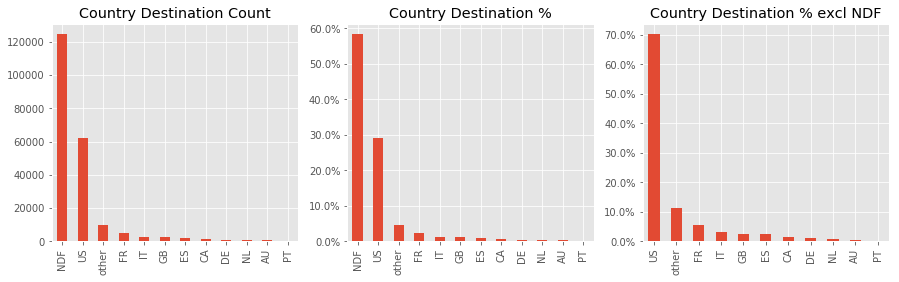

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 4))
country_counts = train.country_destination.value_counts()
country_counts.plot(kind='bar',title='Country Destination Count',ax=axes[0])
ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %',ax=axes[1] )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])
booked_count = train[train.country_destination != 'NDF'].country_destination.value_counts()
ax1 = booked_count.div(booked_count.sum()).plot(kind='bar',title='Country Destination % excl NDF',ax=axes[2] )
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()])

We can see that nearly 60% of users do not make a booking. Of the users that do book about 70% do so in the US. We have very imbalanced classes and will need to keep this in mind when training our model.

Let's take a look at the rleationship between some of our key features and country_destination. 

Gender doesn’t tell us much... 

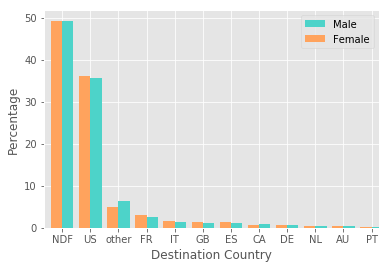

In [30]:
women = sum(train['gender'] == 'FEMALE')
men = sum(train['gender'] == 'MALE')

female_destinations = train.loc[train['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = train.loc[train['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

width = 0.4
male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)
plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

plt.show()

Create a matrix of charts comparing the categorical variables to 'country_destination':

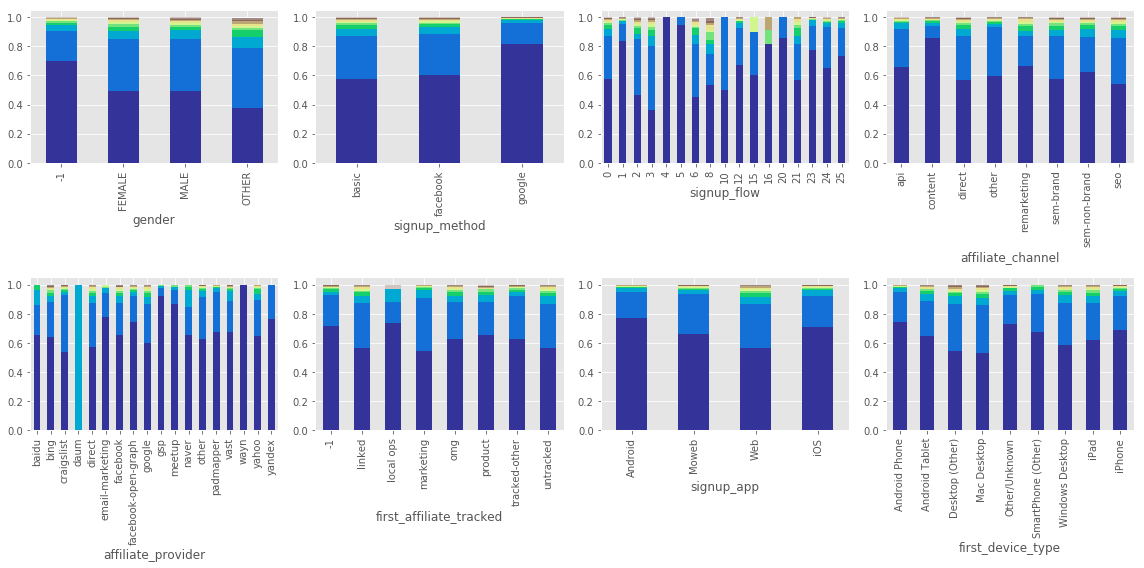

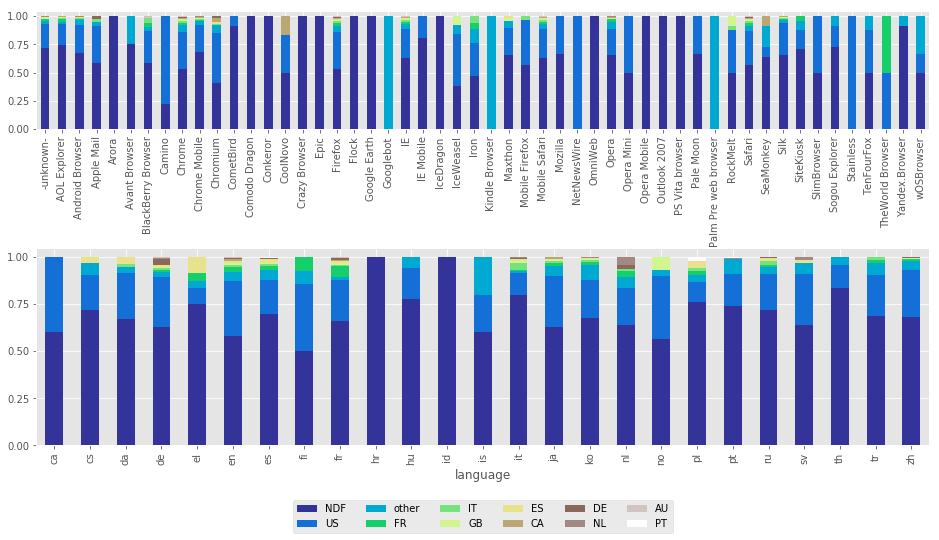

In [47]:
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['gender', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider', 
            'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'language']
from matplotlib.colors import Colormap
fig, ax4 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
def pltCatVar(var,axis,ax_num):
    ctab = pd.crosstab([train[var]], train.country_destination).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num],legend=False, 
                         colormap='terrain')
for i,var in enumerate(cat_vars[:8]):
    pltCatVar(var,ax4,i)
plt.tight_layout()
fig, ax5 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharey=True)
for i,var in enumerate(cat_vars[8:]):
    pltCatVar(var,ax5,i)
box = ax5[0].get_position()
ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
ax5[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6)

Observations:

- unknown gender book less frequently than those with a known one while users with gender 'other' book more frequently
- users with the 'google' signup_method book less frequently than 'basic' or 'facebook'
- users with signup_flow 3 book more frequently than any other category while several have nearly 100% 'NDF'
- users with affiliate_channel 'content' book less frequently than other categories
- users with first_affiliate_tracked 'local ops' book less frequently than other categories
- users with signup_app 'Web' booked the most frequently, while those with 'Android' booked the least
- users with first_device_type 'Mac_Desktop' booked the most frequently, while those with 'Android Phone' booked the least
- first_browser highlights the wide variety used, it is difficult to glean any meaningful insights beyond that some obscure browsers have very high or very low booking frequencies
- the chart on language is somewhat surprising given that all the users were from the US - there are a large number of languages represented and this may warrant further investigation



### Model Fitting
[*all code in this section is written in CoffeeScript generated using H20 flow]

Upload and parse training data:

In [ ]:
setupParse source_frames: [ "trainairbnb.csv"]
    parseFiles
  source_frames: ["trainairbnb.csv"]
  destination_frame: "Key_Frame__trainairbnb1.hex"
  parse_type: "CSV"
  separator: 44
  number_columns: 26
  single_quotes: false
  column_names: ["id","date_account_created","weekday_account_created","weekend_account_created","year_account_created","month_account_created","day_account_created","timestamp_first_active","seconds_delay_activation","weekday_first_active","weekend_first_active","year_first_active","month_first_active","day_first_active","gender","age","signup_method","signup_flow","language","affiliate_channel","affiliate_provider","first_affiliate_tracked","signup_app","first_device_type","first_browser","country_destination"]
  column_types: ["String","Time","Numeric","Enum","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Enum","Numeric","Numeric","Numeric","Enum","Numeric","Enum","Numeric","Enum","Enum","Enum","Enum","Enum","Enum","Enum","Enum"]
  delete_on_done: true
  check_header: 1
  chunk_size: 4194304

Build Gradient Boosting Machine with 1000 trees of max depth 10:

In [ ]:
getFrameSummary "Key_Frame__trainairbnb1.hex"

assist buildModel, null, training_frame: "Key_Frame__trainairbnb1.hex"
    
buildModel 'gbm', {"model_id":"gbm-eb72fa07-aeef-481e-ae6b-683396b7085d","training_frame":"Key_Frame__trainairbnb1.hex","nfolds":0,"response_column":"country_destination","ignored_columns":["id"],"ignore_const_cols":true,"ntrees":"1000","max_depth":"10","min_rows":10,"nbins":20,"seed":-1,"learn_rate":0.1,"sample_rate":1,"col_sample_rate":1,"score_each_iteration":false,"score_tree_interval":0,"balance_classes":false,"max_confusion_matrix_size":20,"max_hit_ratio_k":0,"nbins_top_level":1024,"nbins_cats":1024,"r2_stopping":1.7976931348623157e+308,"stopping_rounds":0,"stopping_metric":"AUTO","stopping_tolerance":0.001,"max_runtime_secs":0,"learn_rate_annealing":1,"distribution":"AUTO","huber_alpha":0.9,"checkpoint":"","col_sample_rate_per_tree":1,"min_split_improvement":0.00001,"histogram_type":"AUTO","categorical_encoding":"AUTO","custom_metric_func":"","build_tree_one_node":false,"sample_rate_per_class":[],"col_sample_rate_change_per_level":1,"max_abs_leafnode_pred":1.7976931348623157e+308,"pred_noise_bandwidth":0,"calibrate_model":false}

Ready the test data...

In [ ]:
setupParse source_frames: [ "testairbnb.csv"]
    parseFiles
  source_frames: ["testairbnb.csv"]
  destination_frame: "Key_Frame__testairbnb2.hex"
  parse_type: "CSV"
  separator: 44
  number_columns: 25
  single_quotes: false
  column_names: ["id","date_account_created","weekday_account_created","weekend_account_created","year_account_created","month_account_created","day_account_created","timestamp_first_active","seconds_delay_activation","weekday_first_active","weekend_first_active","year_first_active","month_first_active","day_first_active","gender","age","signup_method","signup_flow","language","affiliate_channel","affiliate_provider","first_affiliate_tracked","signup_app","first_device_type","first_browser"]
  column_types: ["String","Time","Numeric","Enum","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Enum","Numeric","Numeric","Numeric","Numeric","Numeric","Enum","Numeric","Enum","Enum","Enum","Enum","Enum","Enum","Enum"]
  delete_on_done: true
  check_header: 1
  chunk_size: 4194304

Apply the GBM to make a prediction...

In [ ]:
predict model: "gbm-eb72fa07-aeef-481e-ae6b-683396b7085d", frame: "Key_Frame__testairbnb2.hex", predictions_frame: "prediction-290e2778-e756-499e-b2a1-13600e1f4c18"

Combine prediction with test data...

In [ ]:
bindFrames "combined-prediction-290e2778-e756-499e-b2a1-13600e1f4c18", [ "prediction-290e2778-e756-499e-b2a1-13600e1f4c18", "Key_Frame__testairbnb2.hex" ]

Submit to Kaggle for a score of...............................................................................................

0.70871

The majority of entrants scored 0.86+ so still plenty of work to do.

That will have to wait till another time. The next step is feature engineering on the 'sessions' data set which contains data on the online actions of Airbnb's users. Unfortunately this dataset is 600MB+ and Trifacta Wrangler's size limit is 100MB for their free edition. 

I've achieved the purpose of this exercise and seen that Trifacta Wrangler is a far more productive and effective means of performing data preprocessing. Hope you enjoyed it.